In [ ]:
from ipywidgets import IntSlider
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [ ]:
import pandas as pd
import scipy
import shap
import numpy as np
import ZCA as zca
import statsmodels.api as sm
import matplotlib as plt

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

import sklearn
from sklearn.preprocessing import *
from sklearn import preprocessing
import matplotlib.pyplot as plt

import IPython

import os
os.environ['R_HOME'] = '/mnt/distvol/R/4.0.5/lib64/R/'
import rpy2.robjects as R
from rpy2.robjects import pandas2ri
pandas2ri.activate()

from numpy import mean
from numpy import arange
from numpy import std
from numpy import absolute
from pandas import read_csv
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import shap
from sklearn.linear_model import ElasticNet
import seaborn as sns
from ModelDiagnostics import Plot
from sklearn.cluster import DBSCAN
from clustergram import Clustergram
import urbangrammar_graphics as ugg
from sklearn.preprocessing import scale
from scipy import stats
from scipy.special import boxcox, inv_boxcox
from scipy.stats import f

import dtale
from pandas_profiling import ProfileReport

In [ ]:
#power = PowerTransformer(method='box-cox')

def testNormal (x):    
    
    k2, p = stats.normaltest(x)
    alpha = .001
    #print("p = {:g}".format(p))    
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        #print(p)
        #print(alpha)
        print("The null hypothesis can be rejected")
        xt, _ = stats.yeojohnson(x)
        #xt, _ = stats.boxcox(x)        
        print(_)
        xt = pd.DataFrame(xt)
        
        return _, pd.DataFrame(xt).set_index(x.index)
    else:
        print("The null hypothesis cannot be rejected")    
        return 1, pd.DataFrame(x)

def inverse_boxcox (data, lambdas):
    return inv_boxcox(data, lambdas.values)
    
def transform_boxcox_l(data, l_):
    transformed = pd.DataFrame()

    for i in range(0,len(data.columns)):
        #print(i)
        if l_.iloc[i].values == 1:
            inner_scale = data.iloc[:,i]            
        else:
            inner_scale = pd.DataFrame(stats.boxcox((data.iloc[:,i]), lmbda=l_.iloc[i].values))
            
        inner_scale.index = data.index
        transformed = pd.concat([transformed,inner_scale],axis=1)
        
    transformed.columns = data.columns
    return transformed

def transform_boxcox (data):
    transformed = pd.DataFrame()
    transformed_lambdas = pd.DataFrame()

    for i in range(0,len(data.columns)):
        l, inner_scale = testNormal(data.iloc[:,i])
        inner_scale.set_index(data.index)

        transformed_lambdas = pd.concat([transformed_lambdas,pd.DataFrame(pd.Series(l))],axis=0)
        transformed = pd.concat([transformed,inner_scale],axis=1)
        
    transformed.columns = data.columns
    return transformed, transformed_lambdas

def revert_boxcox (data, lambdas):
    reverted = pd.DataFrame()

    for i in range(0,len(data.columns)):        
        if lambdas.iloc[i].values == 1 :
            revert = data.iloc[:,i]
        else:
            revert = pd.DataFrame(inv_boxcox(data.iloc[:,i].values, lambdas.iloc[i].values))            
        revert.index = data.index
        reverted = pd.concat([reverted,revert],axis=1)
        
    reverted.columns = data.columns
    return reverted


In [ ]:
def get_deltas(data):

    R.r('''
               f <- function(values) {
                        #system("which openssl")

                        library(snpEnrichment)
                        library(arfima)
                        library(parallel)
                        library(forecast)                    

                        dset <- lapply(1:ncol(values),function(x)
                        {
                            column = values[,x]


                            #tryCatch(invisible(capture.output(suppressMessages(suppressWarnings(
                            #{
                              varvefd = arfima(column)
                              d = summary(varvefd)$coef[[1]][1]
                              return(d)
                            #}
                           #)
                           #))),
                            #error=function(e)
                              #{
                                #d = 1
                                #return(d)
                              #})

                        })    

                        unlist(dset)

                }
                ''')

    r_f = R.globalenv['f']
    d=R.conversion.rpy2py((r_f(R.conversion.py2rpy(data.dropna()))))
    return(d)


In [ ]:
def get_weights(d, num_k):
    r"""Calculate weights ($w$) for each lag ($k$) through
    $w_k = -w_{k-1} \frac{d - k + 1}{k}$.
    
    Args:
        d (int): differencing value.
        num_k (int): number of lags (typically length of timeseries) to calculate w.
    """
    w_k = np.array([1])
    
    for k in range(1, num_k):
        w_k = np.append(w_k, -w_k[-1] * ((d - k + 1)) / k)
        
    w_k = w_k.reshape(-1, 1) 
    
    return w_k

def get_weights_floored(d, num_k, floor=1e-3):
    r"""Calculate weights ($w$) for each lag ($k$) through
    $w_k = -w_{k-1} \frac{d - k + 1}{k}$ provided weight above a minimum value
    (floor) for the weights to prevent computation of weights for the entire
    time series.
    
    Args:
        d (int): differencing value.
        num_k (int): number of lags (typically length of timeseries) to calculate w.
        floor (float): minimum value for the weights for computational efficiency.
    """
    w_k = np.array([1])
    k = 1
    
    while k < num_k:
        w_k_latest = -w_k[-1] * ((d - k + 1)) / k
        if abs(w_k_latest) <= floor:
            break

        w_k = np.append(w_k, w_k_latest)
        
        k += 1

    w_k = w_k.reshape(-1, 1) 
    
    return w_k

def frac_diff(df, d, floor=1e-3):
    r"""Fractionally difference time series via CPU.
    
    Args:
        df (pd.DataFrame): dataframe of raw time series values.
        d (float): differencing value from 0 to 1 where > 1 has no FD.
        floor (float): minimum value of weights, ignoring anything smaller.
    """
    # Get weights window
    weights = get_weights_floored(d=d, num_k=len(df), floor=floor)
    weights_window_size = len(weights)
    
    # Reverse weights
    weights = weights[::-1]
    
    # Blank fractionally differenced series to be filled
    df_fd = []

    # Slide window of time series, to calculated fractionally differenced values
    # per window
    for idx in range(weights_window_size, df.shape[0]):
        # Dot product of weights and original values
        # to get fractionally differenced values
        date_idx = df.index[idx]
        df_fd.append(np.dot(weights.T, df.iloc[idx - weights_window_size:idx]).item())
    
    # Return FD values and weights
    df_fd = pd.DataFrame(df_fd)
    
    return df_fd, weights

In [ ]:

all_data = pd.read_csv('/mnt/distvol/combined_set.csv')
all_data.index = all_data.iloc[:,0]
all_data = all_data.iloc[:,1:]

filter_ = all_data.columns.tolist()

In [ ]:
def f3(Y):
    
    #Y = x
    #output_slider_variable.value
    internalFilter = filter_.copy()
    internalFilter.remove(Y)
    all_data_ = pd.concat([all_data[Y],all_data[internalFilter]], axis=1)    
    #print(all_data_.describe())
    display(all_data_.describe())
    x_ticks = all_data_.index[np.arange(0, len(all_data.index), 5)]
    plt.plot(all_data_[Y])
    plt.xticks(x_ticks, rotation = 45)
    plt.show()        
    plt.hist(all_data_[Y], bins='auto')
    plt.show()
    diff = pd.DataFrame((all_data_[Y]-all_data_[Y].shift(-1))).dropna()
    plt.hist(diff, bins='auto')
    plt.show()
    return(all_data_)
    
out = interactive(f3, Y=filter_)

#output_slider_variable.observe(f4, 'value')

print("choose Y")
display(out)


In [ ]:
d = get_deltas(out.result)

In [ ]:
d_ = dtale.show(out.result)
d_.open_browser()
d_._url  

In [157]:
import concurrent.futures
from concurrent.futures import wait, ALL_COMPLETED
from fracdiff import fdiff

cores = int(len(os.sched_getaffinity(0)))

def getDifferenced(i):
    #v = d[[i]]
    #gquant_gpu, weights = frac_diff(all_data.iloc[:, i], d=d[[i]], floor=5e-5)
    
    a = np.array(out.result.iloc[:, i])
    
    return fdiff(a, n=d[i], axis=0)
    #gquant_gpu, weights = frac_diff(all_data.iloc[:, i]), d=v, floor=5e-5)

pool01 = concurrent.futures.ProcessPoolExecutor(cores)

futures01 = [pool01.submit(getDifferenced, args) for args in range(0,len(d))]

wait(futures01, timeout=None, return_when=ALL_COMPLETED)


DoneAndNotDoneFutures(done={<Future at 0x7f2f36260040 state=finished returned ndarray>, <Future at 0x7f2f36260070 state=finished returned ndarray>, <Future at 0x7f2f362620d0 state=finished returned ndarray>, <Future at 0x7f2f36262100 state=finished returned ndarray>, <Future at 0x7f2f36262130 state=finished returned ndarray>, <Future at 0x7f2f3625a160 state=finished returned ndarray>, <Future at 0x7f2f362a62e0 state=finished returned ndarray>, <Future at 0x7f2f36262310 state=finished returned ndarray>, <Future at 0x7f2f3625a340 state=finished returned ndarray>, <Future at 0x7f2f36262370 state=finished returned ndarray>, <Future at 0x7f2f36260490 state=finished returned ndarray>, <Future at 0x7f2f3625a490 state=finished returned ndarray>, <Future at 0x7f2f362604c0 state=finished returned ndarray>, <Future at 0x7f2f3625a4c0 state=finished returned ndarray>, <Future at 0x7f2f36260550 state=finished returned ndarray>, <Future at 0x7f2f362ac5e0 state=finished returned ndarray>, <Future at 0

In [158]:
Differenced_Set = pd.DataFrame()
for f in range(0,len(futures01)):
    value = pd.DataFrame(futures01[f].result())
    Differenced_Set = pd.concat([Differenced_Set,value],axis=1)
    
Differenced_Set.columns = out.result.columns
Differenced_Set.index = out.result.index

In [ ]:
if False:
    for f in range(0,len(futures01)):
        #print(f)
        #print(len(futures01[f].result()))
        plt.hist(Differenced_Set.iloc[:,f], bins='auto')  # arguments are passed to np.histogram
        plt.show()
        Differenced_Set.iloc[:,1].plot()
        plt.show()
        plt.hist(all_data.iloc[:,f], bins='auto')  # arguments are passed to np.histogram
        plt.show()
        all_data.iloc[:,1].plot()
        plt.show()    



In [ ]:
c = out.result.corr()
#.abs()
s = c.unstack()
so = s.sort_values(kind="quicksort", ascending=False)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

def critical_r(n, alpha = .05 ):
    df = n - 2
    critical_t = scipy.stats.t.isf(alpha / 2, df)
    critical_r = np.sqrt( (critical.t^2) / ( (critical.t^2) + df ) )
    return(critical_r)

def xcorr(x, y, maxlags=10):
    Nx = len(x)
    if Nx != len(y):
        raise ValueError('x and y must be equal length')

    c = np.correlate(x, y, mode=2)

    if maxlags is None:
        maxlags = Nx - 1

    if maxlags >= Nx or maxlags < 1:
        raise ValueError('maxlags must be None or strictly positive < %d' % Nx)

    c = c[Nx - 1 - maxlags:Nx + maxlags]

    return c

def getLagged_Set(set_, og):

    #set_.index = all_data.index

    maxl = 5
    Lagged_Differenced_Set = pd.DataFrame()
    Lagged_Set = pd.DataFrame()
    #TrainO_Lagged_Set = pd.DataFrame()
    lags = []
    lagcorrs = []
    ogcorrs = []

    for f in range(1,len(set_.columns)):
        #print(f)
        #print(len(futures01[f].result()))

        data_1 = set_.iloc[:,0]
        data_2 = set_.iloc[:,f]

        ogc = np.array(pd.concat([data_1 - np.mean(data_1),data_2 - np.mean(data_2)],axis=1).corr())[1,0]    
        ogcorrs.append(ogc)

        #corr = xcorr(data_1 - np.mean(data_1), data_2 - np.mean(data_2),maxlags=5)

        set1 = data_1 - np.mean(data_1)
        set2 = data_2 - np.mean(data_2)

        corrs_ = []
        for i in range(0,maxl):
            c = np.array((pd.concat([set1,set2.shift(i)],axis=1).dropna()).corr())[0,1]
            corrs_.append(c)

        #corr = np.correlate(data_1 - np.mean(data_1), data_2 - np.mean(data_2),mode='full')
        #plt.plot(corr)
        #plt.show()

        #lag = corr.argmax() - (len(data_1) - 1)
        lag = abs(pd.Series(corrs_)).idxmax()

        #print(corr)
        lagc = np.array(pd.concat([data_1 - np.mean(data_1),(data_2 - np.mean(data_2)).shift(lag)],axis=1).corr())[1,0]

        #print(lag)

        #print(ogc)
        #print(lagc)

        #print(lag)
        #plt.plot(data_1, 'r*')
        #plt.plot(data_2, 'b*')

        lag_merged = pd.concat([data_1 - np.mean(data_1),(data_2 - np.mean(data_2)).shift(lag)],axis=1)

        x_ticks = all_data.index[np.arange(0, len(all_data.index), 5)]
        #plt.xticks(x_ticks, rotation = 45)    
        #plt.show()

        #plt.scatter(data_2.shift(lag),data_1)
        #plt.show()

        #plot_acf(data_2.shift(lag))
        #plt.show()

        #plot_pacf(data_2.shift(lag))
        #plt.show()

        y = data_1
        X = data_2
        #reg = LinearRegression().fit(X, y)

        #print(reg.score(X, y),reg.coef_,reg.intercept_)

        model = sm.OLS(y,X)
        results = model.fit()
        #print(results.summary())

        Lagged_Differenced_Set = pd.concat([Lagged_Differenced_Set,data_2.shift(lag)],axis=1)
        #TrainO_Lagged_Set = pd.concat([TrainO_Lagged_Set,all_data.iloc[:,f].shift(lag)],axis=1)
        #if lag>0:
            #lag = 0

        Lagged_Set = pd.concat([Lagged_Set,og.iloc[:,f].shift(lag)],axis=1)

        lagcorrs.append(lagc)

        lags.append(lag)

    stats = pd.concat([pd.DataFrame(set_.columns[1:]),pd.DataFrame(lags),pd.DataFrame(lagcorrs),pd.DataFrame(ogcorrs)],axis=1)
        
    return stats, pd.concat([data_1,Lagged_Set],axis=1),  pd.concat([data_1,Lagged_Differenced_Set],axis=1)


In [193]:
Lagged_Set = pd.DataFrame()
Lagged_Differenced_Set = pd.DataFrame()

ls_stats, Lagged_Set, Lagged_Differenced_Set = getLagged_Set(Differenced_Set, out.result)
lso_stats, Lagged_Set_offset, p = getLagged_Set(pd.concat([Differenced_Set.iloc[:,0].shift(-1),Differenced_Set.iloc[:,1:]],axis=1), out.result)
                
Lagged_Set_offset.dropna(inplace= True)

Lagged_Differenced_Set.dropna(inplace= True)


In [213]:
temp = pd.DataFrame()
temp = pd.concat([out.result.iloc[:,0].pct_change().shift(-1),Lagged_Differenced_Set_offset.iloc[:,1:].pct_change()],axis=1).copy().dropna()
Lagged_Differenced_Set_offset = pd.DataFrame()
Lagged_Differenced_Set_offset = temp.copy()
Lagged_Differenced_Set.dropna(inplace= True)
Lagged_Differenced_Set_offset

^SP500TR     DGS10      DTB3    DGS3MO  MORTGAGE30US    DFII10  \
2004-12-31  0.029813 -0.209582 -0.143322 -0.196890     -0.238385 -0.146843   
2005-03-31 -0.003927 -0.094569 -0.063216 -0.092153     -0.176987  0.018920   
2005-06-30  0.040415  0.034497  0.175482  0.174566      0.074665 -0.039422   
2005-09-30  0.009843 -0.116746  0.417131  0.441517     -0.123821  0.106593   
2005-12-31  0.048335  0.012751  0.357139  0.360686     -0.083115  0.139952   
...              ...       ...       ...       ...           ...       ...   
2019-12-31 -0.004005 -0.551885  0.127970  0.127001      0.066825 -8.529080   
2020-03-31 -0.035486  0.498149 -0.000396 -0.015396     -0.184049 -5.188405   
2020-06-30  0.137470 -0.664078 -0.077253 -0.097197     -0.143067  2.416002   
2020-09-30  0.075139 -2.894166 -0.208416 -0.244525     -0.139473  0.742130   
2020-12-31  0.091881 -0.662843 -0.292731 -0.345182      0.094026 -0.103203   

              T5YIFR  BAMLHYH0A0HYM2TRIV  BAMLCC0A1AAATRIV      DGS1  ...  \
2004-12-31  0.071432            0.014314         -0.064610 -0.080019  ...   
2005-03-31 -0.058079           -0.078306         -0.095842 -0.143484  ...   
2005-06-30 -0.028531           -0.183151         -0.034573  0.534713  ...   
2005-09-30  0.017749            0.111420         -0.057027  0.127960  ...   
2005-12-31 -0.026122           -0.152739         -0.092185  0.177989  ...   
...              ...                 ...               ...       ...  ...   
2019-12-31 -0.021766           -0.006429         -0.080974  0.067255  ...   
2020-03-31 -0.056763           -0.125250          0.039167 -0.105110  ...   
2020-06-30 -0.042915           -0.221372          0.117749 -0.174665  ...   
2020-09-30 -0.104181            0.625756          0.020280 -0.272824  ...   
2020-12-31 -0.057047            0.031575         -0.124713 -0.199931  ...   

                 MRK      MSFT       NKE        PG       TRV       UNH  \
2004-12-31 -0.419629  0.038491  0.280214  0.022363 -0.417227  0.488772   
2005-03-31  0.114315  0.044313 -0.169209 -0.005276 -0.049315  0.066219   
2005-06-30  0.104362 -0.244349 -0.306826 -0.001629 -0.226610  0.006567   
2005-09-30 -0.119629 -0.107946  0.035736  0.021776 -0.496634 -0.025885   
2005-12-31 -0.004691  0.174493  0.109139  0.012636  0.165258  0.245652   
...              ...       ...       ...       ...       ...       ...   
2019-12-31  0.027259  0.019542  0.326357  0.115950 -0.102080  0.464894   
2020-03-31 -0.055179  0.030804 -0.226553  0.042054  0.209116  0.053867   
2020-06-30 -0.046507  0.222298 -0.079000 -0.013429  0.545097  0.036271   
2020-09-30  0.061538  0.104864  0.756145 -0.022134 -0.070802  0.176244   
2020-12-31 -0.027301  0.269657  0.508836  0.145954 -0.406186  0.182110   

                  VZ       WMT       WBA       DIS  
2004-12-31  0.046662  0.063807 -0.084918 -0.425913  
2005-03-31 -0.502920 -0.168305 -0.043674 -0.035121  
2005-06-30 -0.037643 -0.385707  0.057429 -0.337017  
2005-09-30 -0.134964  0.100708  0.007481 -0.272541  
2005-12-31 -0.307749  0.087371  0.164231  0.589502  
...              ...       ...       ...       ...  
2019-12-31  0.193353 -0.001888 -0.173549 -0.070563  
2020-03-31 -0.300709 -0.242613 -0.299459 -0.143466  
2020-06-30  0.017509  0.324998  0.088858  0.914602  
2020-09-30  0.245615  0.164708  0.151925 -0.096800  
2020-12-31  0.046098  0.149416 -0.160600 -0.116222  

[65 rows x 91 columns]

In [ ]:
print(ls_stats)
print(lso_stats)

In [ ]:
transformed, lambdas = transform_boxcox(Lagged_Differenced_Set.dropna())

In [ ]:
#Difference (only if not using differenced)
#transformed = (transformed - transformed.shift(-1)).dropna()

In [315]:
cbd = True
ic = True

# evaluate an elastic net model on the dataset
tsize = .20
train, test = train_test_split(Lagged_Differenced_Set_offset.iloc[:,0:], test_size=tsize, shuffle=False)

interaction = PolynomialFeatures(degree=2, include_bias=False, interaction_only=ic)

#train_t, lambdas_t = transform_boxcox(train)

#disabled boxcox
if cbd:
    train_t = train

scaler = preprocessing.StandardScaler().fit(train_t)

#
train_s = pd.DataFrame(scaler.transform(train_t))
train_s.columns = train.columns
train_s.index = train.index  

train_t = train_s

#test_t = transform_boxcox_l(test, lambdas_t)

#disabled boxcox
if cbd:
    test_t = test

test_s = pd.DataFrame(scaler.transform(test_t))
test_s.columns = test.columns
test_s.index = test.index

test_t = test_s

y_train = pd.DataFrame(train_t.iloc[:,0])

#exclude y

X_inter_train = pd.DataFrame(interaction.fit_transform(train_t.iloc[:,1:]), columns=interaction.get_feature_names(input_features=pd.DataFrame(train_t.iloc[:,1:]).columns))

    #apply ZCA each time a set of factors are removed (i.e. iteratively)
 #trf = zca.ZCA().fit(X_inter_train)
  #trf = zca.ZCA().fit(X_train)

 #X_train = pd.DataFrame(trf.transform(X_inter_train))
  #X_train = pd.DataFrame(trf.transform(X_train))
 #X_train.columns=X_inter_train.columns
  #X_train.columns=X_train.columns
  #X_train.index = train.index

#X_inter_alt = X_train.iloc[:, np.array(range(0,len(all_data.iloc[:,2:].columns)))]
#print(X_inter_alt.head(3))

y_test = pd.DataFrame(test_t.iloc[:,0])

X_inter_test = pd.DataFrame(interaction.fit_transform(test_t.iloc[:,1:]), columns=interaction.get_feature_names(input_features=pd.DataFrame(test_t.iloc[:,1:]).columns))

 #X_test = pd.DataFrame(trf.transform(X_inter_test))
  #X_test = pd.DataFrame(trf.transform(X_test))

 #X_test.columns=X_inter_test.columns
  #X_test.columns=X_test.columns
  #X_test.index = test.index

#X_inter_t_alt = X_test.iloc[:, np.array(range(0,len(all_data.iloc[:,2:].columns)))]
#X_inter_t_alt.head()


In [316]:
# define model evaluation method
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import randint

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define model
ratios = arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]

 #model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=4, verbose=0, precompute='auto')

model = ElasticNet()
grid = dict()
# fit model

grid['alpha'] = alphas
grid['l1_ratio'] = ratios

#search = HalvingRandomSearchCV(model, grid,resource='n_samples',max_resources=10,random_state=0)

search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

 #results = search.fit(X_inter_train, y_train)
#results = search.fit(X_train, y_train)

results = search.fit(X_inter_train, y_train)

 #model.fit(X_inter_train, y_train)
# summarize chosen configuration

print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

print(results.best_estimator_)
best_model = ElasticNet(alpha=results.best_estimator_.alpha, l1_ratio = results.best_estimator_.l1_ratio)

#pd.concat([all_data[Y],all_data_int],axis=1)



MAE: -0.682
Config: {'alpha': 10.0, 'l1_ratio': 0.17}
ElasticNet(alpha=10.0, l1_ratio=0.17)


In [317]:
best_model.fit(X_inter_train,train_t.iloc[:,0])

trainScore = best_model.score(X_inter_train, y_train, sample_weight=None)
testScore = best_model.score(X_inter_test, y_test, sample_weight=None)
print(trainScore)
print(testScore)


0.0
-0.07670119860984714


0
2004-12-31  1
2005-03-31  0
2005-06-30  1
2005-09-30  1
2005-12-31  1
2006-03-31  1
2006-06-30  1
2006-09-30  1
2006-12-31  1
2007-03-31  1
2007-06-30  0
2007-09-30  1
2007-12-31  0
2008-03-31  1
2008-06-30  0
2008-09-30  0
2008-12-31  0
2009-03-31  1
2009-06-30  1
2009-09-30  1
2009-12-31  1
2010-03-31  1
2010-06-30  0
2010-09-30  1
2010-12-31  1
2011-03-31  1
2011-06-30  0
2011-09-30  1
2011-12-31  1
2012-03-31  1
2012-06-30  1
2012-09-30  1
2012-12-31  1
2013-03-31  1
2013-06-30  1
2013-09-30  1
2013-12-31  1
2014-03-31  1
2014-06-30  1

0    0.5
dtype: float64

In [421]:
#SVM

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
interaction = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
from sklearn.model_selection import StratifiedShuffleSplit
import random

#pd.DataFrame(Lagged_Set.iloc[:,0].shift(-1)).hist()
#Lagged_Differenced_Set = (all_data - all_data.shift(-1)).dropna()
#Lagged_Differenced_Set_f = pd.concat([Lagged_Differenced_Set.iloc[:,0].shift(-1),Lagged_Differenced_Set.iloc[:,1:]],axis=1)

set_ = pd.DataFrame()
set_ = Lagged_Differenced_Set_offset.copy()

X, y = set_.iloc[:,1:],  set_.iloc[:,0]

y = pd.DataFrame(np.where(y > 0, 1, 0))
y.index = set_.index

train_size = .7
test_size = 1-train_size

#test_I = random.sample(list(X.index), int(np.round(test_size*len(X))))
#train_I set(test_I) ! set()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)
#df.sample(frac=0.5, replace=True, random_state=1)
#class balance
one = y_train[y_train==0].dropna().sample(len(X_train), replace=True, random_state=1)
two = y_train[y_train==1].dropna().sample(len(X_train), replace=True, random_state=1)
train_index = []
train_index = np.append(one.index,two.index)

scaler = preprocessing.StandardScaler().fit(X_train.loc[train_index])

X_train_transformed = pd.DataFrame(scaler.transform(X_train.loc[train_index]))
X_train_transformed.columns = X_train.columns

X_inter_train = X_train_transformed

#X_inter_train = pd.DataFrame(interaction.fit_transform(X_train_transformed), columns=interaction.get_feature_names(input_features=pd.DataFrame(X_train_transformed).columns))

#trf = zca.ZCA().fit(X_inter_train)

#X_inter_train = pd.DataFrame(trf.transform(X_inter_train))
#X_inter_train.columns=pd.DataFrame(X_inter_train).columns
#X_inter_train.index = X_train.index

clf = svm.SVC(kernel='sigmoid', C=1, random_state=42)

scores = cross_val_score(clf, X_inter_train, y_train.loc[train_index], cv=10)

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

clf = svm.SVC(C=1).fit(X_inter_train, y_train.loc[train_index])

X_test_transformed = pd.DataFrame(scaler.transform(X_test))
X_test_transformed.columns = X_test.columns
X_test_transformed.index = X_test.index

X_inter_test = X_test_transformed

#X_inter_test = pd.DataFrame(interaction.fit_transform(X_test_transformed), columns=interaction.get_feature_names(input_features=pd.DataFrame(X_test_transformed).columns))

#X_inter_test = pd.DataFrame(trf.transform(X_inter_test))



0.82 accuracy with a standard deviation of 0.16


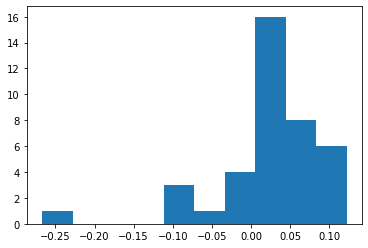

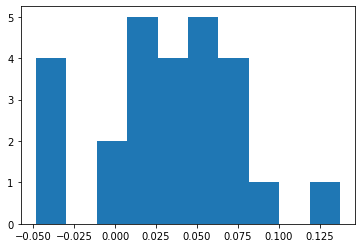

Ttest_indResult(statistic=-0.7337521644115618, pvalue=0.46583921573122944)

In [422]:
from scipy import stats

a = set_.iloc[:,0].loc[X_train.index]
b = set_.iloc[:,0].loc[X_test.index]
plt.hist(a)
plt.show()
plt.hist(b)
plt.show()
stats.ttest_ind(a,b, equal_var = False)


Index(['2004-12-31', '2005-03-31', '2005-06-30', '2005-09-30', '2005-12-31',
       '2006-03-31', '2006-06-30', '2006-09-30', '2006-12-31', '2007-03-31',
       '2007-06-30', '2007-09-30', '2007-12-31', '2008-03-31', '2008-06-30',
       '2008-09-30', '2008-12-31', '2009-03-31', '2009-06-30', '2009-09-30',
       '2009-12-31', '2010-03-31', '2010-06-30', '2010-09-30', '2010-12-31',
       '2011-03-31', '2011-06-30', '2011-09-30', '2011-12-31', '2012-03-31',
       '2012-06-30', '2012-09-30', '2012-12-31', '2013-03-31', '2013-06-30',
       '2013-09-30', '2013-12-31', '2014-03-31', '2014-06-30'],
      dtype='object')

In [425]:
predicted = clf.predict(X_inter_test)
#predicted.index = y_test.index

clf.score(X_inter_test, y_test)

#clf.predict(X_test)
print(predicted)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [327]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV#create new a knn model
knn2 = KNeighborsClassifier(metric='euclidean',weights='distance')#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)#fit model to data
knn_gscv.fit(X_inter_train, y_train)
#check top performing n_neighbors value
print(knn_gscv.best_params_)
#check mean score for the top performing value of n_neighbors
print(knn_gscv.best_score_)

knn = KNeighborsClassifier(n_neighbors = knn_gscv.best_params_['n_neighbors'],metric='euclidean',weights='distance')
knn.fit(X_inter_train,y_train)
knn.predict(X_inter_test)
knn.score(X_inter_test, y_test)

{'n_neighbors': 3}
0.7964285714285715


0.7692307692307693

In [426]:
#logistic
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
# define model
ratios = arange(0, 1, 0.01)
alphas = (10 ** np.linspace(-1, 1, 10))/10
alphas = np.append(alphas,[10.0, 100.0])

model = SGDClassifier(loss="log", penalty="elasticnet")
grid = dict()
# fit model

grid['alpha'] = alphas
grid['l1_ratio'] = ratios

search_l = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

results_l = search_l.fit(X_inter_train, y_train.loc[train_index])

 #model.fit(X_inter_train, y_train)
# summarize chosen configuration

print('MAE: %.3f' % results_l.best_score_)
print('Config: %s' % results_l.best_params_)



MAE: 0.000
Config: {'alpha': 0.01668100537200059, 'l1_ratio': 0.08}


In [427]:
from sklearn.calibration import CalibratedClassifierCV
print(results_l.best_estimator_)
best_model_l = SGDClassifier(alpha=results_l.best_estimator_.alpha, l1_ratio = results_l.best_estimator_.l1_ratio)

#calibrator = CalibratedClassifierCV(best_model_l, cv='prefit')
#model=calibrator.fit(X_inter_train, y_train)

best_model_l.fit(X_inter_train,y_train.loc[train_index])

#sgd = SGDClassifier()

#sgd.partial_fit(X_inter_train,y_train, classes=[0,1])

print(pd.DataFrame(np.transpose(best_model_l.coef_)).set_index(X_inter_train.columns))

trainScore_l = best_model_l.score(X_inter_train, y_train.loc[train_index], sample_weight=None)
testScore_l = best_model_l.score(X_inter_test, y_test, sample_weight=None)
print(trainScore_l)
print(testScore_l)

#print(help(KNeighborsClassifier))
best_model_l.predict(X_inter_test)

SGDClassifier(alpha=0.01668100537200059, l1_ratio=0.08, loss='log',
              penalty='elasticnet')
                     0
DGS10        -0.247222
DTB3         -0.079110
DGS3MO       -0.194978
MORTGAGE30US  0.044664
DFII10       -0.553962
...                ...
UNH           0.410737
VZ            0.581737
WMT           0.170714
WBA           0.103710
DIS          -0.106363

[90 rows x 1 columns]
1.0
0.7307692307692307


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [ ]:
# multivariate output multi-step 1d cnn example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dense, SimpleRNN, GRU, LSTM
from keras.optimizers import SGD
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

Lagged_Differenced_Set = (all_data - all_data.shift(-1)).dropna()

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out, xcolumns, ycolumns):
    
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, xcolumns], sequences[end_ix:out_end_ix, ycolumns]
        X.append(seq_x)
        y.append(seq_y)
    
    return array(X), array(y)

#n_steps_in = int(np.floor(len(train)*.8))
print(len(Lagged_Differenced_Set))
n_steps_in = int(np.round(len(Lagged_Differenced_Set)/2))
print(len(Lagged_Differenced_Set) - n_steps_in)
print(n_steps_in)
#n_steps_out = int(len(train)-n_steps_in)
n_steps_out = 1
print(n_steps_out)

#ycolumns = range(0,len(transformed.columns))
ycolumns = range(0,len(Lagged_Differenced_Set.columns[0:1].values))
xcolumns = range(1,len(Lagged_Differenced_Set.columns[1:]))

#trainInner, valid = train_test_split(trainOuter, test_size=0.15, shuffle=False)
#trainInner_whitened = pd.DataFrame(trf.transform(trainInner.iloc[:,1:])).set_index(trainInner.index)
#valid_whitened = pd.DataFrame(trf.transform(valid.iloc[:,1:])).set_index(valid.index)
#test_whitened = pd.DataFrame(trf.transform(test.iloc[:,1:])).set_index(test.index)

trainOuter_whitened=pd.DataFrame(trf.transform(trainOuter.iloc[:,1:])).set_index(trainOuter.index)

X, y = split_sequences(np.array(Lagged_Differenced_Set), n_steps_in, n_steps_out, xcolumns, ycolumns)

#for i in range(len(X)):
#    print(X[i], y[i])
    
#flatten output

if len(ycolumns) > 0:
    n_output = y.shape[1] * y.shape[2]
    y = y.reshape((y.shape[0], n_output))

n_features = X.shape[2]

# define model
modelCNN = keras.models.Sequential([
    keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)),
    keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)),
    keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)),
    keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)),
    keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)),
    keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)),
    keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)),
    keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(n_output)
])

# fit model
#model.fit(X, y, epochs=7000, verbose=0)

epochs_ = 200
batch_size_ = 25

#np.random.seed(42)
#tf.random.set_seed(42)


#model.compile(optimizer='adam', loss='mse')
modelCNN.compile(loss="MAPE", optimizer="rmsprop",metrics=['MAPE'])

#model6.compile(loss="MAPE", optimizer="rmsprop",metrics=['MAPE'])

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    shuffle = False)
                                                    #random_state=42)
scaler = preprocessing.StandardScaler().fit(X_train)

X_train_transformed = pd.DataFrame(scaler.transform(X_train))
X_train_transformed.columns = X_train.columns

X_test_transformed = pd.DataFrame(scaler.transform(X_test))
X_test_transformed.columns = X_test.columns
X_test_transformed.index = X_test.index

    #new_series = pd.DataFrame(ts_train_scaled).append(pd.DataFrame(ts_valid_scaled)).append(pd.DataFrame(ts_test_scaled))

    #series_reshaped = np.array([new_series[i:i + (n_steps+n_ahead)].copy() for i in range(len(data) - (n_steps+n_ahead))])  
    
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                    test_size=0.33,
                                                    shuffle = False)
                                                    #random_state=42)    

#model6.compile(loss="MAPE", optimizer="rmsprop",metrics=['MAPE'])
historyCNN = modelCNN.fit(X_train, y_train, epochs=epochs_,batch_size=batch_size_,validation_data=(X_valid, y_valid), verbose=0)
#history6 = model6.fit(X_train, y_train, epochs=epochs_,batch_size=batch_size_,validation_data=(X_valid, y_valid), verbose=0)
#history = model.fit(X_train, y_train, epochs=epochs_,batch_size=batch_size_,verbose=0)


In [ ]:
import matplotlib as mpl
plot_learning_curves(historyCNN.history["loss"], history.history["val_loss"])
plt.show()
#plot_learning_curves(history6.history["loss"], history.history["val_loss"])
#plt.show()

In [ ]:
import matplotlib.pyplot as plt
#multi
yhat = modelCNN.predict(X_test, verbose=0)

predicted = []
original = []
if len(ycolumns) > 1:
    results = yhat.reshape(len(y_test), int(yhat.shape[1]/X_test.shape[2]), len(transformed.columns))
    for i in range(0,len(results)):
        predicted.append(pd.DataFrame(results[i])[0][0])
        original.append(pd.DataFrame(y_test[i])[0][0])
        #print(pd.DataFrame(results[i])[0][0])
        #print(pd.DataFrame(y_test[i])[0][0])
else:
    results = yhat
    for i in range(0,len(results)):
        predicted.append(results[i])
        original.append(y_test[i])
        #print(pd.DataFrame(results[i]))
        #print(pd.DataFrame(y_test[i]))
        
plt.scatter(predicted,original)

pd.concat([pd.DataFrame(predicted),pd.DataFrame(original)],axis=1)

In [ ]:
coef = pd.DataFrame(best_model.coef_).set_index(X_inter_train.columns)

a_coef = abs(coef)
a_coef.sort_values(by=[0],ascending=False,inplace=True)
chosen_few = a_coef[a_coef>0].dropna().index.values

scaler_ = preprocessing.StandardScaler().fit(transformed)

#
train_ = pd.DataFrame(scaler_.transform(transformed))
train_.columns = transformed.columns
train_.index = transformed.index  

X_inter_train_ = pd.DataFrame(interaction.fit_transform(train_.iloc[:,1:]), columns=interaction.get_feature_names(input_features=pd.DataFrame(train_.iloc[:,1:]).columns))

max_pvalue = 1
New_Names = X_inter_train.columns
X_b = X_inter_train_[chosen_few]
while (max_pvalue > .05):
        
    trf = zca.ZCA().fit(X_b)
        
    X_b_z = pd.DataFrame(trf.transform(X_b))
    X_b_z.columns=pd.DataFrame(X_b).columns
    X_b_z.index = train_.index

    model_ = sm.OLS(train_.iloc[:,0],sm.tools.tools.add_constant(X_b_z, prepend=True, has_constant='skip'))        
    #model_ = sm.OLS(pd.DataFrame(pd.concat([train_.iloc[:,0],X_b_z],axis=1),sm.tools.tools.add_constant(X_b_z, prepend=True, has_constant='skip'))        
    results_ = model_.fit()

    set_ = X_b.columns.tolist()
    
    max_pvalue = max(results_.pvalues[1:])
    if (max_pvalue > .05):
        print(max_pvalue)
        max_pname = (results_.pvalues[1:]).idxmax(axis=1)
        set_.remove(max_pname)
        New_Names = set_
    
        X_b = X_inter_train_[New_Names]
        X_b.index = X_inter_train_.index

#from statsmodels.formula.api import ols
#lm = ols(pd.DataFrame(train_.iloc[:,0]) ~ sm.tools.tools.add_constant(X_b_z, prepend=True, has_constant='skip')).fit()
#table = sm.stats.anova_lm(model_, type=3)
#print(table)
print(results_.summary())

In [ ]:
def findNaNCols(df_):
    for col in df_:        
        num_NaNs = df_[col].isnull().sum()
        if num_NaNs > 0:
            print(f"Column: {col}")
            print(f"Number of NaNs: {num_NaNs}")

findNaNCols(X_b_z)

In [ ]:

linear_plot = Plot.LinearRegressionResidualPlot(X_b_z, pd.DataFrame(train_.iloc[:,0]))
lm = linear_plot.fit()
summary, diag_res = linear_plot.diagnostic_plots(lm)
print("Summary of Regression\n:{}".format(summary))
print("Diagnostic Tests of Regression\n:{}".format(diag_res))

plt.show()

%matplotlib inline

#sns.pairplot(pd.concat([pd.DataFrame(train[Y]),X_b_z],axis=1), hue=Y, height=2);

pd.concat([pd.DataFrame(train[Y]),X_b_z],axis=1).hist()

plt.show()

model_s = sklearn.linear_model.LinearRegression()
model_s.fit(X_b_z, pd.DataFrame(train_[Y]))

shap.initjs()
e = shap.explainers.Linear(model_s, X_b_z)

shap_values = e.shap_values(X_b_z)
shap.summary_plot(shap_values, X_b_z)
shap.plots.heatmap(e(X_b_z))

In [ ]:
from scipy.stats import f

from statsmodels.graphics.gofplots import ProbPlot
residuals_normalized = lm.get_influence().resid_studentized_internal
cooks = lm.get_influence().cooks_distance[0]
cooks = np.round(f.pdf(cooks,len(lm.tvalues)+1, len(lm.fittedvalues)-len(lm.tvalues)-1),2)

res_std = lm.get_influence().resid_std

leverage = lm.get_influence().hat_matrix_diag

plt.hist(pd.DataFrame(leverage))
plt.show()

plt.hist(pd.DataFrame(cooks))
plt.show()

plt.hist(pd.DataFrame(residuals_normalized))
plt.show()


testNormal(residuals_normalized)

w = res_std
x = cooks
y = leverage
z = residuals_normalized

fitted_y = lm.fittedvalues

labels_ = fitted_y.index

outlier_check = pd.concat([pd.DataFrame(x),pd.DataFrame(y),pd.DataFrame(z),pd.DataFrame(w)],axis=1).set_index(labels_)

outlier_check.columns =  ['cooks', 'leverage', 'tsres', 'sres']

qq = ProbPlot(residuals_normalized)

c_thresh = .1
l_thresh = (2*(len(lm.tvalues)-1)/len(lm.fittedvalues))
s_thresh = max(qq.theoretical_quantiles)

print("Outlier threshold's")
print("Cooks distance: > .1+")
print("Leverage: > " + str(l_thresh) + " to " + str(3 * (len(lm.tvalues)-1)/len(fitted_y)))
print("Studentized residuals: > " + str(s_thresh))
print()

flag = []

for i in range(0,len(outlier_check)):
    if( (outlier_check.iloc[i][0] >= c_thresh) or (outlier_check.iloc[i][1] >= l_thresh) or (abs(outlier_check.iloc[i][2]) >= s_thresh) ):
        print(outlier_check.iloc[i])
        print()
        flag.append(True)
    else:
        flag.append(False)

outlier_check = pd.concat([outlier_check,pd.DataFrame(flag).set_index(labels_)],axis=1)

outlier_check.columns =  ['cooks', 'leverage', 'tsres', 'sres', 'flagged']

print(np.flip(np.argsort(cooks), 0))
#print(outlier_check)

search = outlier_check[outlier_check['flagged']==1].index.to_list()

rows = []

for i in search:
    v = outlier_check.index.to_list().index(i)
    rows.append(v)

print(rows)

In [ ]:
def custom_style(row):

    color = 'white'
    if bool(row.flagged) == True:
        color = 'orange'

    return ['background-color: %s' % color]*len(row.values)

all_data[set(all_data.columns) & set(New_Names)]

outlier_check.style.apply(custom_style, axis=1).apply(custom_style, axis=1).background_gradient(cmap ='viridis')


In [ ]:
df1 = y_train.columns.to_list()
df2 = list(set(set(all_data.columns) & set(New_Names)))

flattened = [] 
for sublist in df1,df2: 
    for val in sublist: 
        flattened.append(val) 

all_data.iloc[rows][flattened].style.background_gradient(cmap ='viridis')